# Neural Network Q Learning Part 2: Looking at what went wrong

In the previous part, we created a simple Neural Network based player and had it play against the Random Player, the Min Max Player, and the non-deterministic Min Max player. While we had some success, overall results were underwhelming:

| Player | NN Player 1st | NN Player 2nd |
| --- | --- | --- |
| Random | Yeah!    | Kind of |
| Min Max | Mixed - All or nothing    | Mixed - All or nothing  |
| Rnd Min Max | Somtimes / Mixed | Nope |

## What could have gone wrong?

We start by looking at our code and identifying possible reasons why things may have gone less than optimal:

* Bugs in the code or other fundamental screw-ups.
* The network we defined is not suitable for this task: Input features not optimal, not enough layers, layers not big enough, sub-optimal activation function, sub-optimal optimizer, sub-optimal weight initialization, sub-optimal loss function.
* Bad values for other hyper-parameters: Optimizer learning rate, reward discount, win/loss/draw rewards.
* The training data wasn't optimal.
* The Tic Tac Toe Q function is fundamentally unlearnable by Neural Networks.

Well, this is quite a list. Randomly tweaking and seeing what happens is not really feasible. Too many possible ways to do so and each of them would take a long time to evaluate - at least on my computer. 

Let's make a quick assessment and come up with some hypotheses about each of the above. Hopefully we can identify some more likely candidates and discard some others.

### Bugs in the code or other fundamental screw ups.

Possible, but hard to confirm. Maybe we calculate the rewards incorrectly, or we feed the trainig data into the network incorrectly, or we use TensorFlow incorrectly, maybe we don't even create the graph correctly? We know that we didn't screw up completely as the Neural Netwok does learn quite well in some scenarios / cases. This doesn't mean we don't have some nasty bugs in there, but for the moment this might not be the most promising avenue to presue. Maybe some bugs will surface while we look close at some of the other options.

### Our network is not good.

#### Input features

We encode the board state as 3x9=27 bits indicating naughts, crosses, and empty fields on the board. There are other possible ways we could do this:

1. We could use an array of 9 integers encoding crosses, naughts, and empty spaces.
2. We could feed in our board hash value as a sinlge interger input.
3. We could create and add some hand-crafted features: Another array indicating moves that would win the game or lose the game; mark potential forks etc.
4. We could feed the board in as 2D features planes instead of 1D feature vectors.

Option 1) is possible, but as far as I remember the conensus seems to be that bit features are better than value-encoded features for cases like game board states. It's also what the professionals seem to use, e.g. DeepMind for [AplhaZero](https://deepmind.com/documents/119/agz_unformatted_nature.pdf). There are siginificant differences in other parts of our approach and the one used in AlphaZero, and I don't seem to be able to find any hard references for bit vs value encoding right now, but I'm reasonably confident we're probably not too wrong in what we do here. Option 2) should be even worse in this case.

Options 3) would almost certainly improve things, but I explicitly don't want to do this. The goal here really is to train a Neural Network to play Tic Tac Toe based on reinforcement alone, i.e. with no prior human game strategy knowledge built into the system. By suggesting that certain features like win/lose in one move, or forks are important would artificially add such information. So, while it may work, we won't do this.

Option 4) is an interesting one. The fact that we use a 1D vector certainly loses some of the obviously existing 2D features on the board. For a human, it would be very hard to play Tic Tac Toe if presented with a board in this way, especially if they have to do so without transforming it back to a 2D representation in their head. On the other hand, I don't see how our particular network would be able to exploit the 2D representaion. If we would be using a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network), this would be different, but for our simple network I don't think it would make a difference. Feel encouraged however to give it a try and report back. Especially if it worked!

In summary, while there is some uncertainty about our input feature vector, it's probably ok I think.

#### The network itself

We only use 1 hidden layer and this layer is not particularly large. So, this is one aspect we defintiely should have a look at.

We use `ReLu` as activation function and there are other options we could try, such as `tanh`, `leaky relu`, `sigmoid`, etc. Might be worth trying, but `ReLu` seems to be generally regarded as an allrounder to be used unless you have a particular reason not to. Based on my very limited understanding of what I'm doing here, I don't really see a good reason to use any of the others, so we'll leave that one alone as well for the time being. If you want to play around with this, maybe give the `leaky ReLu` a go and let us know how it went.

Similar to the activiation function, the [GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) should be a good alrounder to be used here. But again, there are many other options one could try, e.g. the popular [AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer). 

Regarding the loss function, I'm reasonably confident here. We want to approximate a function (the Q function of Tic Tac Toe), so this should make it a regression problem, which as I understand it should mean that [Mean Squared Error](tf.losses.mean_squared_error) should be a good choice. 

Weight initialization is in my limited experience surprisingly important, and can significantly impact performance. E.g. in the worst case of initializiung all weights with the same number it basically collapses the layer widths to 1 as all nodes in a layer would always have the same value. We use the [Variance Scaling initializer](tf.contrib.layers.variance_scaling_initializer) which shouldn't be a bad choice as far as I can tell - especially if we want to add more layers to our network, but again, there are many other options we could try.

In the input feature section, we previously discussed that we do lose some information due to the fact that we use a 1D vector to represent a fundamentally 2D board state. In our simple network, I don't see how we could eploit the 2D sturctures. There are however Neural Networks called [Convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) that can do this. It would probably be worthwhile to give this a try.

There are also various other, more sophisticated network topologies we can try to teach a Neural Network how to play Tic Tac Toe: Double Q Network, Policy Gradient, Actor Critic, etc.

#### Other Hyper Parameters

Then there are the hyper-parameters that let us tune the network without chaning its topology: Learning rate, reward discount, win/loss/draw rewards are all values we can be changed and which potentially will make performance better or worse. We'll have to see if we can get some clues on whether we need to make changes here.

### Training data

The training data is pretty much determined by our use of the Reinforcement Learning approach. I.e. making the current network play games using its current Q function approximation and then update its weights based on the outcome. There are some things we could do a bit differently however, and potentially better:

* We currently always chose the move that we estimate is the best one. This is called a *greedy* strategy. This carries the risk that we get stuck in a particular pattern and never take a risk and investigate some other potential moves. E.g. in the worst case this might mean that due random weight initialization the move that would be best ends up with an estimated Q value that is so bad that it would never be chosen. Since we will never ever chose this move it will never get a chance to cause a positive reward and thus get a chance to have its Q value estimate corrected. A potential solution for this is to use a *$\epsilon$ - greedy* strategy, where we *most of the time* use the move with the highest Q value, but occasionally (with probability $\epsilon$ - thus the name) chose a sub-optimal move to encourage better exploration of our possible action-space.
* Another limitation of our current approach is that we only feed the last game into the weight update. The risk here is that if a network loses a lot it will mostly get losses as training input. This could potentially cause a self-reinforcing  situation where the lack of any positive rewards will lead the network to predict that no matter what it does it will always lose, thus all moves are just bad. We should test this hypothesis, and if true might need to add a cache of previously played games to feed back into the network, potentially artificially boosting the number of samples with positive reward outcomes.

We will give this a try and see if it helps.

### The Tic Tac Toe Q function is fundamentally unlearnable by Neural Networks
 
 Yeah, nah. Theoretically possible maybe, but extremly unlikely. Given the success others have with Neural Networks in related and much more complex tasks, this is probably not it. 
 
 Most serious approaches do however use a slightly different approach than we do by combining a Neural Network with other techniques such as variations of Tree Search, e.g. [Monte Carlo tree search](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search). This wouldn't make much sense in our Tic Tac Toe scenario since we have seen in the Min Max Player part that a tree search on its own can master Tic Tac Toe already without breaking a sweat. There is not much a Neural Network could contribute here even if we severly restrict the search depth.
 
 

# Becoming less greedy

Based on our investigation above, it looks like a promising first step might be to use a less greedy action policy.

Becoming less greedy is quite straight forward. We simply add a parameter $\epsilon$, and with probability $\epsilon$ we don't chose what we think is the best move, but a random other move. 

In the beginning of our training we want to be quite adventurous and try all kinds of moves. The more our training advances the more confident we should be in our Q value estimates and thus the less likely we should be to try random other moves. This means we will also need a second parameter to continuously decrease $\epsilon$ over time.

This is implemented in [EGreedyNNQPlayer.py](./tic_tac_toe/EGreedyNNQPlayer.py).

It is very similar to our previous version, with the following changes. When we select a move, instead of 
```
    move = np.argmax(probs)
```

we now do
```
    if self.training is True and np.random.rand(1) < self.random_move_prob:
        move = board.random_empty_spot()
    else:
        move = np.argmax(probs)
```
 and during training we reduce the probability of making a random move:
 
```
    self.random_move_prob *= self.random_move_decrease
```

Let's see how it goes. We will use the new $\epsilon$-greedy strategy and also play a bit with the other hyperparameters:

After 100 game we have draws: 16, Player 1 wins: 0, and Player 2 wins: 84.
Which gives percentages of draws: 16.00%, Player 1 wins: 0.00%, and Player 2 wins:  84.00%
After 100 game we have draws: 13, Player 1 wins: 0, and Player 2 wins: 87.
Which gives percentages of draws: 13.00%, Player 1 wins: 0.00%, and Player 2 wins:  87.00%
After 100 game we have draws: 2, Player 1 wins: 0, and Player 2 wins: 98.
Which gives percentages of draws: 2.00%, Player 1 wins: 0.00%, and Player 2 wins:  98.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 2, Player 1 wins: 0, and Player 2 wins: 98.
Which gives percentages of draws: 2.00%, Player 1 wins: 0.00%, and Player 2 wins:  98.00%
After 10

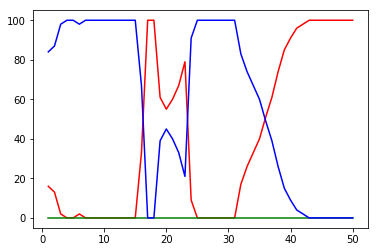

In [7]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

from util import evaluate_players
from tic_tac_toe.TFSessionManager import TFSessionManager
from tic_tac_toe.RandomPlayer import RandomPlayer
from tic_tac_toe.EGreedyNNQPlayer import EGreedyNNQPlayer
from tic_tac_toe.MinMaxAgent import MinMaxAgent

tf.reset_default_graph()

nnplayer = EGreedyNNQPlayer("QLearner1", learning_rate=0.001, reward_discount=0.99, random_move_decrease=0.99)
mm_player = MinMaxAgent()
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, mm_player, num_battles=50)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)


Feel encouraged to play with the example above and try out different combinations. Overall I didn't notice much change - on occasion however it seemsed to be able to break out of a complete losing streak and find a strategy that resulted in 100% draws. To see if this is statistically significant however would require a lot of runs. Many more than I have time or patience for. Especially since it clearly didn't actually solve the problem to a degree that is acceptable.

# One last try - the whole she-bang
